In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\Conor\Anaconda3\python.exe
3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [214]:
Breast_DF.columns

Int64Index([ 912,  916,  920,  924,  928,  932,  936,  940,  944,  948,
            ...
            1764, 1768, 1772, 1776, 1780, 1784, 1788, 1792, 1796, 1800],
           dtype='int64', length=223)

In [171]:
np.savetxt("E:\Breast_DF_columns.csv", Breast_DF.columns, delimiter=",")

In [227]:
mie = pd.read_csv("E:\Breast_DF.Rubber", header = None)
mie.index = Breast_DF.index
mie.columns = np.flip(Breast_DF.columns)

In [257]:
from numpy import genfromtxt

mie_values = np.fliplr(genfromtxt('E:/Breast_DF.RMieS', delimiter=','))

mie = pd.DataFrame(mie_values,
                   index = Breast_DF.index,
                   columns = Breast_DF.columns
                  )

In [246]:
mie = pd.read_csv('E:/Breast_DF.RMieS', header = None)
mie.index = Breast_DF.index
mie.columns = np.flip(Breast_DF.columns)
mie = mie.iloc[::-1]

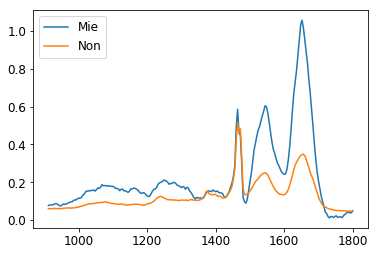

In [258]:
plt.plot(mie.head().mean(axis = 0), label = "Mie")
plt.plot(Breast_DF.mean(axis = 0), label = "Non")

plt.legend()

# Home-PC

In [4]:
import os.path

file_place = r"C:\Users\C\OneDrive"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_data_raw"))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\C\\OneDrive\\Breast_data_raw'

In [4]:
import os.path

file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_data_raw"))

In [5]:
Breast_DF.head()

912   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.094676   
                                                              B4    0.094676   
                                                              B4    0.095110   
                                                              B4    0.095979   
                                                              B4    0.097282   

                                                                        916   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.093373   
                                                              B4    0.093808   
                                                              B4    0.093808   
                                                              B4    0.095110   
                                                              B4    0.095979   

                                                                        920   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.095110   
                                                              B4    0.095110   
                                                              B4    0.095545   
                                                              B4    0.096848   
                                                              B4    0.097716   

                                                                        924   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.095545   
                                                              B4    0.095545   
                                                              B4    0.095979   
                                                              B4    0.097282   
                                                              B4    0.099019   

                                                                        928   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.096848   
                                                              B4    0.096848   
                                                              B4    0.097282   
                                                              B4    0.098151   
                                                              B4    0.099888   

                                                                        932   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.097282   
                                                              B4    0.097282   
                                                              B4    0.097716   
                                                              B4    0.099019   
                                                              B4    0.100322   

                                                                        936   \
Sex Type      Stage Pathology                 Grade Label Age Core             
F   Malignant IIa   Invasive ductal carcinoma 1     Blood 40  B4    0.095979   
                                                              B4    0.096848   
                                                              B4    0.096848   
                                                              B4    0.097716   
                                                              B4    0.099019   

                                                                        940   \
Sex Type      Stage Pathology                 Grade Label Age Cor

# Preprocessing

Preprocessing method, maybe make this all one pipe?

In [203]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler

steps = [
         #("Normalise", Normalizer(norm = "l1"))
         ("RobustScaler", RobustScaler())
        ]

pipe  = Pipeline(steps)

In [260]:
import Tissue_Analysis_Tools as TAT

PCA_NR_Components = 50

dataframe = TAT.process_data(mie, paraffin = (1340,1490))#, balance = "Type")

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

Breast_DF_P = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Analysis

In [281]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

lb = LabelBinarizer()

DATA = Breast_DF_P.sample(5000)

y_label = "Type"

X = DATA
Y = DATA.reset_index()[y_label]
lb.fit(Y)

Y_b = pd.DataFrame(lb.transform(Y), index = Y.index)

# Keep a separate validation set aside 
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

print(y_train.value_counts())
print(y_valid.value_counts())

# Create dataframes containing the binary labels for each class
y_train = pd.DataFrame(lb.transform(y_train), index = y_train.index)
y_valid = pd.DataFrame(lb.transform(y_valid), index = y_valid.index)

Malignant    3495
NAT           720
Normal        285
Name: Type, dtype: int64
Malignant    382
NAT           77
Normal        41
Name: Type, dtype: int64


In [282]:
DATA.reset_index()["Label"].value_counts()

Malignant Epithelium        2262
Malignant Stroma            1101
Non_malignant Stroma         611
Non_malignant Epithelium     512
Necrosis                     432
Blood                         82
Name: Label, dtype: int64

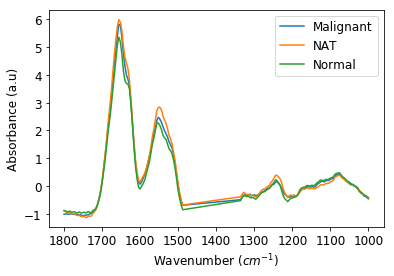

In [283]:
plt.clf()

for name, df in Breast_DF_P.groupby(level = y_label):
    
    plt.plot(df.mean(axis = 0), label = name)

plt.ylabel("Absorbance (a.u)")
plt.xlabel("Wavenumber $(cm^{-1})$")
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [80]:
import xgboost as xgb

In [81]:
binary_classifiers = dict()

for i, name in enumerate(np.unique(Y)):

    # Find out the ratio of positive classes to negative to scale positive weights.
    # Allows for compensation of unbalanced classes without throwing away data.

    pos_ratio = 1/(np.sum(Y_b[:,i])/Y_b[:,i].shape[0])

    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic", early_stopping_rounds = 10, n_classes = 2, n_jobs = -1, scale_pos_weight = pos_ratio)
    
    # Set the parameters which are best for that particular class
    #clf_xgb.set_params(**param_dict[name])
    clf_xgb.fit(X.values,Y_b[:,i])
    
    print("Trained: {}".format(name))

    binary_classifiers[name] = clf_xgb

TypeError: '(slice(None, None, None), 0)' is an invalid key

# HyperOpt Training

In [17]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

This will ouput a score for the current hyperparameter configuration 

In [284]:
%time

binary_classifiers = dict()

for i, name in enumerate(np.unique(Y)):
    
    best_hyperparams = hyper_opt_search(X_train.values,
                                        y_train[i].values,
                                        X_train.reset_index()["Core"],
                                        weight_binary = True,
                                        optimiser = tpe.suggest,
                                        random_state = 42,
                                        cores = 1,
                                        n_evals = 3)
                                #, trials = Trials())
    
    ## TODO: append best classifier to dictionary, store any other
    ## relevant variables with it. Use trials.
    
    clf_xgb = xgb.XGBClassifier()
    
    # Set the parameters which are best for that particular class
    clf_xgb.set_params(**best_hyperparams)
    clf_xgb.fit(X_train.values, y_train[i])
    
    print("Trained: {}".format(name))

    binary_classifiers[name] = clf_xgb

Wall time: 0 ns
	Score 0.881432085183703


	Score 0.8795414167825659


	Score 0.8549164547458318


100%|████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s, best loss: 0.11856791481629703]
Trained: Malignant
	Score 0.8815508449576468


	Score 0.8793172910784274


	Score 0.8916785368114964


100%|████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s, best loss: 0.10832146318850355]
Trained: NAT
	Score 0.8706243018595177


	Score 0.8669734378080031


	Score 0.9051494020632105


100%|████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, best loss: 0.09485059793678952]
Trained: Normal


In [277]:
binary_classifiers["Normal"]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.65, gamma=1.0, learning_rate=0.325,
       max_delta_step=0, max_depth=2, min_child_weight=2.0, missing=None,
       n_estimators=235, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=17.084282460136674, seed=None,
       silent=True, subsample=0.9)

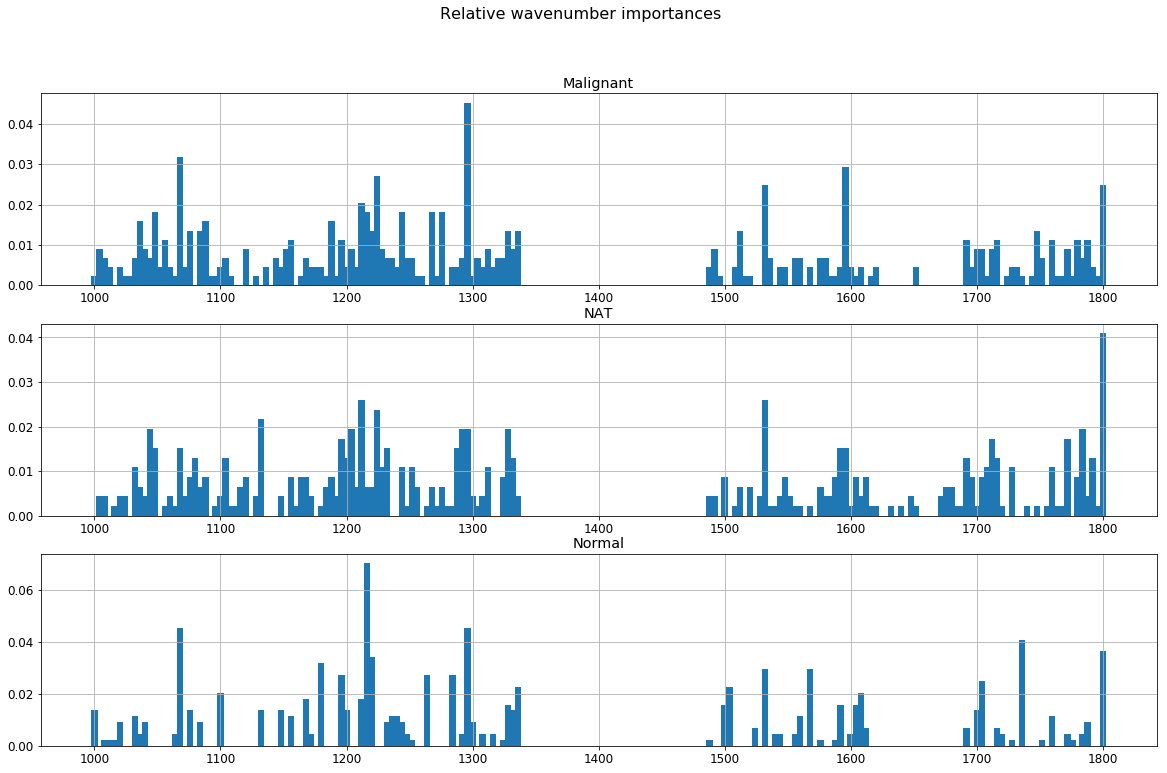

In [285]:
fig, axes = plt.subplots(nrows = len(binary_classifiers), ncols = 1, figsize = (20,len(binary_classifiers)*4))

fig.suptitle("Relative wavenumber importances", fontsize = 16)

for title, plot, ax in zip(binary_classifiers.keys(), binary_classifiers.values(), axes.flatten()):
    
    ax.grid()
    ax.bar(X.columns, plot.feature_importances_, width = 5)
    ax.set_title(title)
    
plt.show()

In [269]:
def binary_predict(x_array, classifiers):
    content = {name: classifier.predict_proba(x_array)[:,1] for name, classifier in classifiers.items()}
    return pd.DataFrame(content).idxmax(axis = 1)

In [270]:
from sklearn.metrics import roc_auc_score

predictions = lb.transform(binary_predict(X_valid.values, binary_classifiers).values)
    
roc_auc_score(y_valid, predictions)

0.9136978774017588

# Mie corrected

In [211]:
from sklearn.metrics import roc_auc_score

predictions = lb.transform(binary_predict(X_valid.values, binary_classifiers).values)
    
roc_auc_score(y_valid, predictions)

0.9215229229466876

This function is used to optimise the hyperparameters of XGboost

In [41]:
def hyper_opt_search(X, y, grouping, weight_binary = False, optimiser = tpe.suggest, random_state = 42, cores = 1, n_evals = 3):
    
    from sklearn.model_selection import train_test_split, GroupKFold
    from sklearn.metrics import roc_auc_score
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def score(params):
        
        loss_cv = []
        
        for train_index, test_index in GroupKFold(2).split(X, y, grouping):

            dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
            dtest = xgb.DMatrix(X[test_index], label=y[test_index])

            watchlist = [(dtest, 'eval'), (dtrain, 'train')]

            xgb_cl = xgb.train(params, dtrain, evals=watchlist, verbose_eval=False)
            #xgb_cl.fit()

            predictions = xgb_cl.predict(dtest, ntree_limit = xgb_cl.best_iteration + 1)

            # TODO: try and get the y_labels from dtest
            score = roc_auc_score(y[test_index], predictions)

            loss = 1 - score
            
            loss_cv.append(loss)
            
        print("\tScore {0}\n\n".format(1-loss))
        return {'loss': loss.mean(), 'status': STATUS_OK}
    
    space = {
        "early_stopping_round" : 10,
        "n_classes" : 2,
        "scale_pos_weight" : 1/(np.sum(y)/y.shape[0]),
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(3, 7, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.9, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': cores,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state      
    }

    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=n_evals)
    
    best["scale_pos_weight"] = space["scale_pos_weight"]
    best["learning_rate"] = best["eta"]
    best["n_estimators"] = int(best["n_estimators"])
    del best["eta"]
    
    return best

# Importing Breast Cancer data

In [16]:
from sklearn.preprocessing import normalize

def import_image(original):
    
    image = original.reshape(original.shape[-1], -1)

    return normalize(image, axis = 0, norm = "l1").reshape(original.shape)

In [22]:
import os
from scipy.io import loadmat

file_place = r"B:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"B:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'B:\\Breast Cancer Data\\br20832_cores\\br20832_cores'

In [214]:
import os
from scipy.io import loadmat

file_place = "/mnt/hgfs/E/Breast Cancer Data/br20832_cores/br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = "/mnt/hgfs/E/Breast Cancer Data/overlay/overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/mnt/hgfs/E/Breast Cancer Data/br20832_cores/br20832_cores'

In [138]:
import os
from scipy.io import loadmat
import imageio

file_place = r"E:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"E:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

#overlays = {image_list[:-4] : imageio.imread(os.path.join(image_list_directory, image_name)) for image_name in image_list}

images = {file_name[:-4] : loadmat(os.path.join(file_place, file_name))["image"] for file_name in file_list[-10:]}

In [139]:
images.keys()

dict_keys(['M14', 'M15', 'M16', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9'])

# Preprocess image

In [165]:
image_ref = "M3"

image = images[image_ref]
#overlay = 

PCA_NR_Components = 50

image_dataframe = pd.DataFrame(image.reshape(-1, image.shape[-1]), columns = Breast_DF.columns)

dataframe = TAT.process_data(image_dataframe, paraffin = (1340,1490))

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

image_P_list = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

image_P = image_P_list.values.reshape(image.shape[0], image.shape[1], -1)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Plotting predictions for image

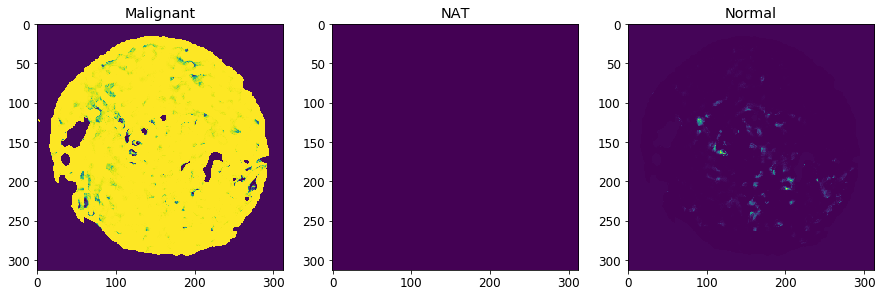

In [279]:
fig, axes = plt.subplots(ncols = len(binary_classifiers), nrows = 1, figsize = (15,10))

pred_cube = individual_predictions(image_P, binary_classifiers)

for ax, name, image in zip(axes.flat, pred_cube.keys(), pred_cube.values()):
    
    ax.set_title(name)
    ax.imshow(image)
    
plt.show()

In [142]:
import matplotlib as mpl

def individual_predictions(image, classifiers):
    
    Pred_cube = {name: classifier.predict_proba(image.reshape(-1, image.shape[-1]))[:,1].reshape(image.shape[0], image.shape[1]) for name, classifier in classifiers.items()}
    
    return Pred_cube

def prediction_plot(image, classifiers, **kwargs):
    
    # Get colours from tab10 colour list
    colours = dict(zip(classifiers.keys(), plt.get_cmap("tab10").colors))
    
    # Prediction values for each 
    Pred_DF = pd.DataFrame({name: classifier.predict_proba(image.reshape(-1, image.shape[-1]))[:,1] for name, classifier in classifiers.items()})

    Pred_DF["Winner_ID"] = Pred_DF.idxmax(axis = 1)
    Pred_DF["Winner_conf"] = Pred_DF.max(axis = 1)

    # RGB image
    RGB = np.array([colours[ID] for ID in Pred_DF["Winner_ID"]]).reshape(image.shape[0], image.shape[1], 3)
    
    # Confidence plot
    conf = Pred_DF["Winner_conf"].values.reshape(image.shape[0], image.shape[1], 1)
    
    # RGBA plot
    rgba = np.concatenate([RGB,conf], axis = 2)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', list(colours.values()), N = len(colours))
    
    # If a threshold is supplied, use it
    if "thresh" in kwargs.keys():
        rgba[np.abs(image_P.mean(axis = 2)) < kwargs.get("thresh")] = [0,0,0,0]
        
    fig, ax = plt.subplots()
    cax = ax.imshow(rgba, cmap = cmap)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, 1, len(classifiers)))
    cbar.ax.set_yticklabels(classifiers.keys())  # horizontal colorbar
    
    return rgba, conf.reshape(conf.shape[0],conf.shape[1])

In [88]:
from skimage.filters import threshold_otsu

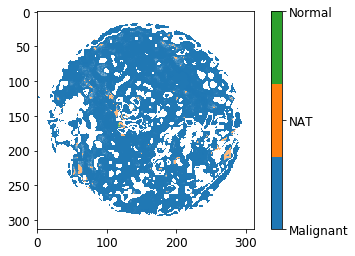

In [280]:
rgba, conf = prediction_plot(image_P, binary_classifiers, thresh = threshold_otsu(image_P.mean(axis = 2)))

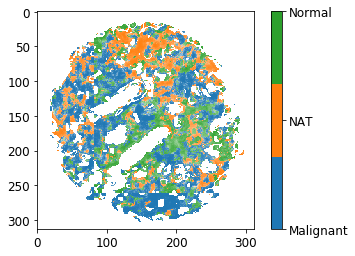

In [143]:
rgba, conf = prediction_plot(image_P, binary_classifiers, thresh = threshold_otsu(image_P.mean(axis = 2)))

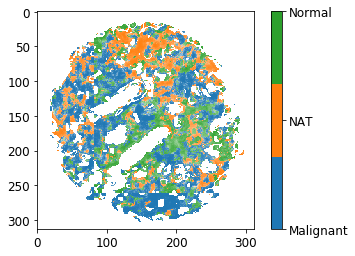

In [143]:
rgba, conf = prediction_plot(image_P, binary_classifiers, thresh = threshold_otsu(image_P.mean(axis = 2)))

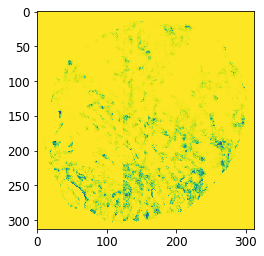

In [124]:
plt.imshow(conf)